In [14]:
class DBSCAN:
    #  Constructor method to initialize DBSCAN parameters -- Rahma this should be input from Firfly
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

    #  Method to perform DBSCAN clustering
    def fit(self, X):
        self.labels = [0] * len(X)
        self.cluster_id = 0
        self.visited = set()

        #  Iterate through each data point -- This can be enhanced we have to think about other ways
        for i in range(len(X)):
            if i in self.visited:
                continue
            self.visited.add(i)
            neighbors = self.region_query(X, i)

            #  Check if the point is a core point, a border point, or noise -- we have to think about the noise too, I think we can implement the algorithm with permitted noise rate
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1  #  Noise point
            else:
                self.expand_cluster(X, i, neighbors)
                self.cluster_id += 1

        return self.labels

    #  Method to find neighbors within the epsilon radius (eps)
    def region_query(self, X, idx):
        neighbors = []
        for i, point in enumerate(X):
            if self.distance(X[idx], point) < self.eps:
                neighbors.append(i)
        return neighbors

    #  Method to expand a cluster by recursively finding connected points -- This implementation was cloned from someone on internet recheck Sara
    def expand_cluster(self, X, idx, neighbors):
        self.labels[idx] = self.cluster_id
        for neighbor_idx in neighbors:
            if neighbor_idx not in self.visited:
                self.visited.add(neighbor_idx)
                neighbor_neighbors = self.region_query(X, neighbor_idx)
                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)
            if self.labels[neighbor_idx] == 0:
                self.labels[neighbor_idx] = self.cluster_id

    #  Method to calculate Euclidean distance between two points -- we can think of new measures but this works really well
    def distance(self, a, b):
        return sum((x - y) ** 2 for x, y in zip(a, b)) ** 0.5


Evaluation Results:
Silhouette Score: 0.6867350732769777
Davies-Bouldin Index: 0.38275284210068616
Calinski-Harabasz Index: 502.82156350235897
Adjusted Rand Index: 0.5681159420289855
Adjusted Mutual Information: 0.7315847607219575


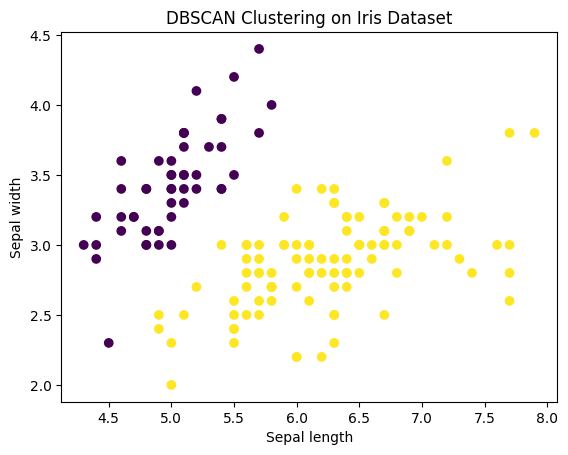

In [10]:
# Import necessary libraries
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt

# Load Iris dataset
iris = load_iris()
X = iris.data  # Feature matrix
true_labels = iris.target  # True labels (if available)

# Perform DBSCAN clustering
eps = 1.6 # Example epsilon value
min_samples = 30 # Example min_samples value
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
predicted_labels = dbscan.fit_predict(X)

# Evaluate clustering results (I read that these are important matrices to evaluate the clustering results)
silhouette = silhouette_score(X, predicted_labels)
davies_bouldin = davies_bouldin_score(X, predicted_labels)
calinski_harabasz = calinski_harabasz_score(X, predicted_labels)
if true_labels is not None:
   adjusted_rand = adjusted_rand_score(true_labels, predicted_labels)
else:
   adjusted_rand = None
if true_labels is not None:
   adjusted_mutual_info = adjusted_mutual_info_score(true_labels, predicted_labels)
else:
 adjusted_mutual_info = None

# Print evaluation results
print("Evaluation Results:")
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)
if adjusted_rand is not None:
    print("Adjusted Rand Index:", adjusted_rand)
if adjusted_mutual_info is not None:
    print("Adjusted Mutual Information:", adjusted_mutual_info)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('DBSCAN Clustering on Iris Dataset')
plt.show()


In [9]:
'''This is just a testing code; I'm not building it from scratch.
This is the first step to learning how the DBSCAN can receive values
from the Firefly algorithm, and how the Firefly algorithm works.'''
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
# Load Iris dataset
iris = load_iris()
X = iris.data  # Feature matrix

# Define the objective function to be maximized (evaluation metric)
def objective_function(params, X):
    min_samples, eps = params
    dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
    predicted_labels = dbscan.fit_predict(X)

    # Check if there is more than one label
    unique_labels = np.unique(predicted_labels)
    if len(unique_labels) <= 1:
        return -1  # Return a negative value as a placeholder for fitness

    silhouette = silhouette_score(X, predicted_labels)  # Compute silhouette score
    return silhouette  # Return silhouette score as fitness

#num_dimensional here equal 2 corresponding to the parameters of the optimization problem (eps and min_samples in DBSCAN).
def initialize_fireflies(num_fireflies, num_dimensions):
    fireflies = np.zeros((num_fireflies, num_dimensions))

    # Expand the range for eps and min_samples
    min_samples_range = (1, 50)
    eps_range = (0.1, 5.0)

    fireflies[:, 0] = np.random.randint(min_samples_range[0], min_samples_range[1] + 1, size=num_fireflies)
    fireflies[:, 1] = np.random.uniform(eps_range[0], eps_range[1], size=num_fireflies)

    # return array of initialized fireflies.
    return fireflies



def attractiveness(light_i, light_j, distance):
    return light_i / (1 + distance)  # Attractiveness function

#this is a function related to the existing equation of the firefly movment
def move_fireflies(fireflies, attractiveness_matrix, beta, alpha):
    num_fireflies, num_dimensions = fireflies.shape
    for i in range(num_fireflies):
        for j in range(num_fireflies):
            if attractiveness_matrix[i, j] > attractiveness_matrix[i, :].max():
                distance = np.linalg.norm(fireflies[i] - fireflies[j])
                fireflies[i] += beta * (fireflies[j] - fireflies[i]) + alpha * (np.random.rand(num_dimensions) - 0.5)
    return fireflies

#start here
def firefly_algorithm(num_fireflies, num_dimensions, max_generations, X):

    fireflies = initialize_fireflies(num_fireflies, num_dimensions)
    best_solution = None
    best_fitness = float('-inf')

    for generation in range(max_generations):
        for i in range(num_fireflies):
            for j in range(num_fireflies):
                if objective_function(fireflies[j], X) > objective_function(fireflies[i], X):
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    attractiveness_matrix[i, j] = attractiveness(objective_function(fireflies[i], X),
                                                                 objective_function(fireflies[j], X),
                                                                 distance)

        fireflies = move_fireflies(fireflies, attractiveness_matrix, beta, alpha)

        # Update best solution
        for i in range(num_fireflies):
            fitness = objective_function(fireflies[i], X)
            if fitness > best_fitness:
                best_solution = fireflies[i]
                best_fitness = fitness
    #Round the parameters to the nearest integer
    #best_solution = np.round(best_solution).astype(int)
    #print("result ==== " + best_solution)

    return best_solution



# Example
num_fireflies = 40
num_dimensions = 2  # Number of dimensions for each parameter (eps, min_samples)
max_generations = 50
beta = 1
alpha = 0.2

# Initialize attractiveness matrix
attractiveness_matrix = np.zeros((num_fireflies, num_fireflies))

# Perform Firefly Algorithm
best_params = firefly_algorithm(num_fireflies, num_dimensions, max_generations, X)

# Extract best parameters
best_min_samples, best_eps = best_params


# Perform DBSCAN clustering with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
predicted_labels = dbscan.fit_predict(X)

# Evaluate clustering results
silhouette = silhouette_score(X, predicted_labels)

# Print best parameters and silhouette score
print("Best parameters (eps, min_samples):", (best_eps, best_min_samples))
#print the Silhouette score result after the firefly algorithm select the eps and min_sampling parameters
print("Silhouette score:", silhouette)


Best parameters (eps, min_samples): (1.6161174995405096, 30.0)
Silhouette score: 0.6867350732769777
